# Introduction

Dalam notebook ini, kita akan mengeksplorasi sentimen analysis pada beberapa dataset dengan pendekatan transfer learing LLM. Tujuan dari analisis ini adalah untuk mendapatkan wawasan yang lebih dalam dari dataset dan model LLM yang digunakan. 

## Tim Peneliti
Tim penelitian ini terdiri dari mahasiswa Teknik Informatik ITS:
- Muhammad Rifqi Ma'ruf
- Fadhl Akmal

## Dataset
Dataset yang digunakan antara lain:
- Pemilu
- BBM
- Penyakit


# Import Libraries

In [1]:
# Mengunduh lbraries yang dibutuhkan
%pip install transformers
%pip install Sastrawi
%pip install emoji

# Mengunduh / clone repository
!git clone https://github.com/rifqimaruf/indonlu.git

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (500/500), 9.45 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [2]:
# libraries untuk data processing
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, HTML
from collections import defaultdict

# Melakukan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Natural Language Processing Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import defaultdict
import emoji

# Melaukan Handling Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler

# Deep Learning libraries untuk Model IndoBERT
import torch
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch import optim
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR



# Transformers libraries untuk IndoBert
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, BertModel

# IndoNLU utilities untuk Sentiment Analysis
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

import time

# Download libraries tokenizer dan stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Menghapus folder yang sudah ada 
import shutil
# shutil.rmtree('/kaggle/working/indonlu')

# Data Loading

In [4]:
# Membaca dataset Pemilu dan BBM
# pemilu_df = pd.read_csv("/kaggle/input/pemilu/pemilu_raw.csv")
bbm_df = pd.read_csv("/kaggle/input/pemilu/bbm_data_preprocessed.tsv", delimiter='\t')

# Menampilkan beberapa baris dari dataframe
# print("Pemilu DataFrame:")
# display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

BBM DataFrame:


,text,sentiment
0,uang bukti dulu kalau ngetik hy gaes bagus mor...,neutral
1,kayang kaya talaga paikutin gong itong bbm ka...,neutral
2,bajingany mna om apa obral ikn apa apa bo...,negative
3,kamu bicara lahir pas jaman orde baru jadi ert...,negative
4,gaji besar bukan tunjang kerja baik pertamina...,negative


# Data Exploration

In [5]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
# display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
# pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7022 non-null   object
 1   sentiment  7022 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


In [6]:
# 2. Donat Plot
# Fungsi Donat Plot
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [7]:
# # Argument plot untuk Pemilu
# sizes_pemilu = pemilu_df.sentiment.value_counts()
# labels_pemilu = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
# colors_pemilu = ['lightgreen', 'lightskyblue', 'lightcoral']
# explode_pemilu = (0, 0, 0)

# Argument plot untuk BBM
sizes_bbm = bbm_df.sentiment.value_counts()
labels_bbm = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_bbm = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_bbm = (0, 0, 0)

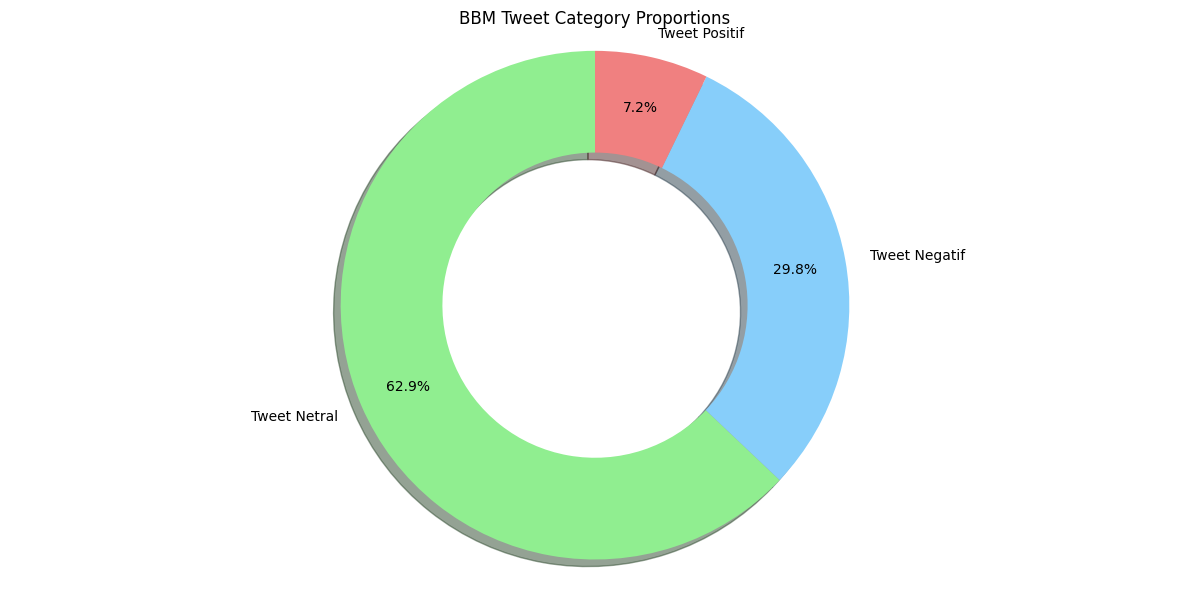

In [8]:
# Membuat Figure dan Axis untuk dua subplot
fig, ax2 = plt.subplots(1, 1, figsize=(12, 6))

# # Plot donat untuk Pemilu
# donut(sizes_pemilu, ax1, 90, labels_pemilu, colors=colors_pemilu, explode=explode_pemilu, shadow=True)
# ax1.set_title('Pemilu Tweet Category Proportions')

# Plot donat untuk BBM
donut(sizes_bbm, ax2, 90, labels_bbm, colors=colors_bbm, explode=explode_bbm, shadow=True)
ax2.set_title('BBM Tweet Category Proportions')

# Menampilkan plot
plt.tight_layout()
plt.show()
     

In [9]:
# 3. Mengecek WordFrequency dan Wordcloud
# Fungsi untuk membuat corpus dari kolom teks
def make_corpus(column):
    corpus_list = [word for text in column for word in text.split(' ')]
    corpus = ' '.join(corpus_list)
    return re.sub(' +', ' ', corpus)  # Mengganti spasi ganda dengan satu spasi

# Fungsi untuk menghitung frekuensi kata
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    df = pd.DataFrame(freqdist.most_common(top), columns=['word', 'freq'])
    return df

In [10]:
# Membuat corpus dan menghitung frekuensi untuk kedua DataFrame
# corpus_pemilu = make_corpus(pemilu_df['text'])
corpus_bbm = make_corpus(bbm_df['text'])

# corpus_freq_pemilu = word_freq(corpus_pemilu, top=20)
corpus_freq_bbm = word_freq(corpus_bbm, top=20)

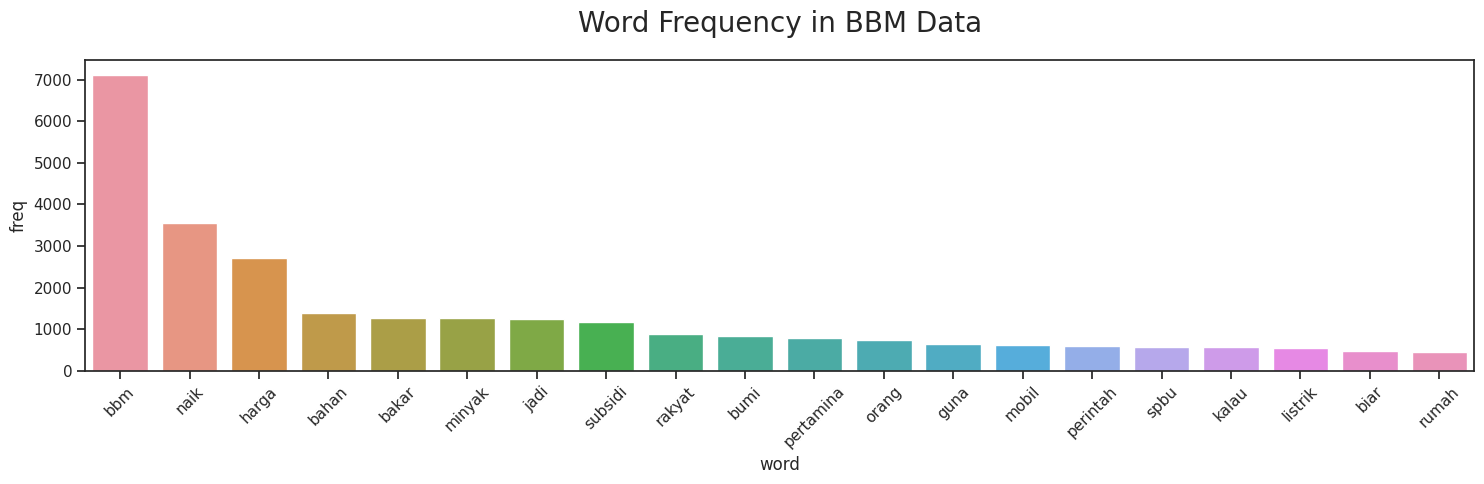

In [11]:
# Mengatur parameter visualisasi
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Membuat figure dengan dua subplot (dua axis)
fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))

# # Plot frekuensi kata untuk data Pemilu
# sns.barplot(x='word', y='freq', data=corpus_freq_pemilu, ax=ax1)
# ax1.set_title('Word Frequency in Pemilu Data')
# ax1.tick_params(axis='x', rotation=45)

# Plot frekuensi kata untuk data BBM
sns.barplot(x='word', y='freq', data=corpus_freq_bbm, ax=ax2)
ax2.set_title('Word Frequency in BBM Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

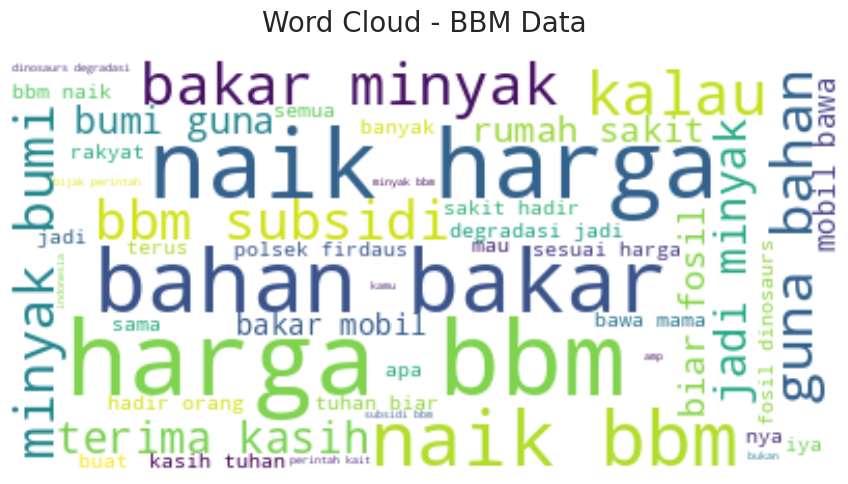

In [12]:
# Membuat WordCloud untuk kedua corpus
fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))

# # WordCloud untuk corpus Pemilu
# wordcloud_pemilu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_pemilu)
# ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
# ax1.axis("off")
# ax1.set_title('Word Cloud - Pemilu Data')

# WordCloud untuk corpus BBM
wordcloud_bbm = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_bbm)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.axis("off")
ax2.set_title('Word Cloud - BBM Data')

plt.tight_layout()
plt.show()

In [13]:
# 4. Mengecek duplikasi value
bbm_df.duplicated().sum()

671

In [14]:
bbm_df.drop_duplicates(inplace=True)

In [15]:
# 5. Menampilkan ukuran baris dan kolom DataFrame
bbm_df.shape

(6351, 2)

# Train and Modelling

In [16]:
# Memuat IndoBERT Tokenizer and Configuration
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = 3 

# Insialisasi IndoBERT Model for Sequence Classification
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Fungsi untuk menyiapkan dataset dan label
def prepare_dataset_and_labels(dataset):
    all_labels = np.array([dataset[i][1] for i in range(len(dataset))])
    all_texts = [dataset[i][0] for i in range(len(dataset))]
    return all_texts, all_labels

# Fungsi untuk mengukur evaluasi matric
def compute_metrics(preds, labels):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    return precision, recall, f1, cm


In [18]:
# Dataset class
class DocumentSentimentDataset(torch.utils.data.Dataset):
    LABEL2INDEX = {"neutral": 0, "positive": 1, "negative": 2}

    def __init__(self, dataset_path, tokenizer, lowercase=False):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.lowercase = lowercase

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t')
        df.columns = ['text', 'sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']
        if self.lowercase:
            text = text.lower()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(), sentiment

In [19]:
# Function to plot the history for a given dataset
def plot_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall and F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.plot(epochs, history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.title('Recall and F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [20]:
def save_model_weights(weights, base_filename="model_fold"):
    for i, weight in enumerate(weights):
        filename = f"{base_filename}_{i+1}.pth"
        torch.save(weight, filename)
        print(f"Model weights for Fold {i+1} saved to {filename}")

In [21]:
def train_and_evaluate(dataset, n_splits=3, n_epochs=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=27)
    history = defaultdict(list)
    model_weights = []
    
    texts, labels = prepare_dataset_and_labels(dataset)
    oversampler = RandomOverSampler()

    # Use mixed precision training for speedup
    scaler = GradScaler()

    for fold, (train_idx, valid_idx) in enumerate(skf.split(texts, labels)):
        print(f'Fold {fold + 1}/{n_splits}')
        start_time = time.time()  # Start timing

        # Apply oversampling on the training data
        train_texts_resampled, train_labels_resampled = oversampler.fit_resample(
            np.array(texts)[train_idx], labels[train_idx]
        )
        resampled_dataset = [(torch.tensor(text), label) for text, label in zip(train_texts_resampled, train_labels_resampled)]
        
        train_subset = Subset(resampled_dataset, list(range(len(resampled_dataset))))
        valid_subset = Subset(dataset, valid_idx)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=32, shuffle=True, num_workers=8)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_subset, batch_size=32, shuffle=False, num_workers=8)

        # Reinitialize the model only once
        if fold == 0:
            model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)
            model = model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        for epoch in range(n_epochs):
            model.train()
            total_train_loss = 0
            list_hyp, list_label = [], []

            train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
            for i, (input_ids, sentiment) in enumerate(train_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                optimizer.zero_grad()

                with autocast():  # Mixed precision
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_train_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f}")

            train_metrics = compute_metrics(list_hyp, list_label)
            train_accuracy = accuracy_score(list_label, list_hyp)
            train_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/len(train_loader):.4f} Precision:{train_metrics[0]:.4f} Recall:{train_metrics[1]:.4f} F1-Score:{train_metrics[2]:.4f} Accuracy:{train_accuracy:.4f}")
            print(f"Confusion Matrix:\n{train_conf_matrix}")

            history['train_loss'].append(total_train_loss / len(train_loader))
            history['train_precision'].append(train_metrics[0])
            history['train_recall'].append(train_metrics[1])
            history['train_f1'].append(train_metrics[2])
            history['train_accuracy'].append(train_accuracy)

            # Validation loop
            model.eval()
            total_val_loss = 0
            list_hyp, list_label = [], []

            valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
            for i, (input_ids, sentiment) in enumerate(valid_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                total_val_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                valid_pbar.set_description(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/(i+1):.4f}")

            val_metrics = compute_metrics(list_hyp, list_label)
            val_accuracy = accuracy_score(list_label, list_hyp)
            val_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch+1}) VALID LOSS:{total_val_loss/len(valid_loader):.4f} Precision:{val_metrics[0]:.4f} Recall:{val_metrics[1]:.4f} F1-Score:{val_metrics[2]:.4f} Accuracy:{val_accuracy:.4f}")
            print(f"Confusion Matrix:\n{val_conf_matrix}")

            history['val_loss'].append(total_val_loss / len(valid_loader))
            history['val_precision'].append(val_metrics[0])
            history['val_recall'].append(val_metrics[1])
            history['val_f1'].append(val_metrics[2])
            history['val_accuracy'].append(val_accuracy)

        avg_train_loss = np.mean(history['train_loss'])
        avg_val_loss = np.mean(history['val_loss'])
        avg_train_precision = np.mean(history['train_precision'])
        avg_val_precision = np.mean(history['val_precision'])
        avg_train_recall = np.mean(history['train_recall'])
        avg_val_recall = np.mean(history['val_recall'])
        avg_train_f1 = np.mean(history['train_f1'])
        avg_val_f1 = np.mean(history['val_f1'])
        avg_train_accuracy = np.mean(history['train_accuracy'])
        avg_val_accuracy = np.mean(history['val_accuracy'])

        print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Average Train Accuracy: {avg_train_accuracy:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}')
        print(f'Average Train Precision: {avg_train_precision:.4f}, Average Validation Precision: {avg_val_precision:.4f}')
        print(f'Average Train Recall: {avg_train_recall:.4f}, Average Validation Recall: {avg_val_recall:.4f}')
        print(f'Average Train F1-Score: {avg_train_f1:.4f}, Average Validation F1-Score: {avg_val_f1:.4f}')
        
        end_time = time.time()  # End timing
        elapsed_time = end_time - start_time
        print(f'Fold {fold + 1} completed in {elapsed_time:.2f} seconds')
        
        # Save the model's weights after the fold
        model_weights.append(model.state_dict())
        
    return history, model_weights

In [22]:
bbm_dataset = DocumentSentimentDataset('/kaggle/input/pemilu/bbm_data_preprocessed.tsv', tokenizer, lowercase=True)

In [23]:
%%time 
# Melatih dataset bbm
history_bbm, weights_bbm = train_and_evaluate(bbm_dataset, n_splits=3, n_epochs=3)

Fold 1/3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(Epoch 1) TRAIN LOSS:0.8098: 100%|██████████| 277/277 [07:00<00:00,  1.52s/it]


(Epoch 1) TRAIN LOSS:0.8098 Precision:0.6083 Recall:0.5936 F1-Score:0.5947 Accuracy:0.5936
Confusion Matrix:
[[1940  251  755]
 [ 576 1577  793]
 [ 866  351 1729]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) VALID LOSS:0.5241: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 1) VALID LOSS:0.5241 Precision:0.8437 Recall:0.8035 F1-Score:0.8099 Accuracy:0.8035
Confusion Matrix:
[[1135   42  296]
 [  15  105   49]
 [  26   32  641]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.3628: 100%|██████████| 277/277 [07:00<00:00,  1.52s/it]


(Epoch 2) TRAIN LOSS:0.3628 Precision:0.8709 Recall:0.8676 F1-Score:0.8682 Accuracy:0.8676
Confusion Matrix:
[[2538   89  319]
 [ 121 2515  310]
 [ 171  160 2615]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) VALID LOSS:0.5149: 100%|██████████| 74/74 [00:36<00:00,  2.06it/s]


(Epoch 2) VALID LOSS:0.5149 Precision:0.8525 Recall:0.8227 F1-Score:0.8314 Accuracy:0.8227
Confusion Matrix:
[[1218   62  193]
 [  15  113   41]
 [  34   70  595]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.2229: 100%|██████████| 277/277 [07:02<00:00,  1.52s/it]


(Epoch 3) TRAIN LOSS:0.2229 Precision:0.9231 Recall:0.9220 F1-Score:0.9221 Accuracy:0.9220
Confusion Matrix:
[[2600   64  282]
 [  78 2788   80]
 [ 104   81 2761]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) VALID LOSS:0.5277: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 3) VALID LOSS:0.5277 Precision:0.8535 Recall:0.8360 F1-Score:0.8407 Accuracy:0.8360
Confusion Matrix:
[[1239   57  177]
 [  23  105   41]
 [  47   39  613]]
Average Train Loss: 0.4651, Average Validation Loss: 0.5222
Average Train Accuracy: 0.7944, Average Validation Accuracy: 0.8207
Average Train Precision: 0.8008, Average Validation Precision: 0.8499
Average Train Recall: 0.7944, Average Validation Recall: 0.8207
Average Train F1-Score: 0.7950, Average Validation F1-Score: 0.8273
Fold 1 completed in 1373.21 seconds
Fold 2/3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) TRAIN LOSS:0.3337: 100%|██████████| 277/277 [07:03<00:00,  1.53s/it]


(Epoch 1) TRAIN LOSS:0.3337 Precision:0.8858 Recall:0.8839 F1-Score:0.8841 Accuracy:0.8839
Confusion Matrix:
[[2567   94  285]
 [ 175 2561  210]
 [ 148  114 2684]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) VALID LOSS:0.2502: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 1) VALID LOSS:0.2502 Precision:0.9198 Recall:0.9043 F1-Score:0.9071 Accuracy:0.9043
Confusion Matrix:
[[1292   52  129]
 [   3  164    2]
 [  13   25  661]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.1890: 100%|██████████| 277/277 [07:03<00:00,  1.53s/it]


(Epoch 2) TRAIN LOSS:0.1890 Precision:0.9348 Recall:0.9343 F1-Score:0.9342 Accuracy:0.9343
Confusion Matrix:
[[2641   63  242]
 [  71 2826   49]
 [ 123   33 2790]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) VALID LOSS:0.2562: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 2) VALID LOSS:0.2562 Precision:0.9211 Recall:0.9116 F1-Score:0.9132 Accuracy:0.9116
Confusion Matrix:
[[1310   32  131]
 [   3  155   11]
 [  22    8  669]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.1382: 100%|██████████| 277/277 [07:04<00:00,  1.53s/it]


(Epoch 3) TRAIN LOSS:0.1382 Precision:0.9548 Recall:0.9544 F1-Score:0.9544 Accuracy:0.9544
Confusion Matrix:
[[2712   45  189]
 [  41 2877   28]
 [  79   21 2846]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) VALID LOSS:0.2702: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 3) VALID LOSS:0.2702 Precision:0.9197 Recall:0.9103 F1-Score:0.9118 Accuracy:0.9103
Confusion Matrix:
[[1307   34  132]
 [   5  155    9]
 [  23    7  669]]
Average Train Loss: 0.3427, Average Validation Loss: 0.3905
Average Train Accuracy: 0.8593, Average Validation Accuracy: 0.8647
Average Train Precision: 0.8629, Average Validation Precision: 0.8851
Average Train Recall: 0.8593, Average Validation Recall: 0.8647
Average Train F1-Score: 0.8596, Average Validation F1-Score: 0.8690
Fold 2 completed in 1380.09 seconds
Fold 3/3


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) TRAIN LOSS:0.1633: 100%|██████████| 277/277 [07:04<00:00,  1.53s/it]


(Epoch 1) TRAIN LOSS:0.1633 Precision:0.9477 Recall:0.9473 F1-Score:0.9472 Accuracy:0.9473
Confusion Matrix:
[[2684   44  218]
 [  31 2877   38]
 [ 108   27 2811]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 1) VALID LOSS:0.1549: 100%|██████████| 74/74 [00:36<00:00,  2.04it/s]


(Epoch 1) VALID LOSS:0.1549 Precision:0.9489 Recall:0.9410 F1-Score:0.9423 Accuracy:0.9410
Confusion Matrix:
[[1349   49   75]
 [   2  165    2]
 [   5    5  688]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.1029: 100%|██████████| 277/277 [07:05<00:00,  1.53s/it]


(Epoch 2) TRAIN LOSS:0.1029 Precision:0.9685 Recall:0.9682 F1-Score:0.9681 Accuracy:0.9682
Confusion Matrix:
[[2762   28  156]
 [  16 2922    8]
 [  62   11 2873]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) VALID LOSS:0.1877: 100%|██████████| 74/74 [00:36<00:00,  2.05it/s]


(Epoch 2) VALID LOSS:0.1877 Precision:0.9444 Recall:0.9380 F1-Score:0.9388 Accuracy:0.9380
Confusion Matrix:
[[1346   20  107]
 [   9  159    1]
 [   2    6  690]]


  0%|          | 0/277 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.0781: 100%|██████████| 277/277 [07:05<00:00,  1.54s/it]


(Epoch 3) TRAIN LOSS:0.0781 Precision:0.9765 Recall:0.9764 F1-Score:0.9763 Accuracy:0.9764
Confusion Matrix:
[[2806   24  116]
 [   8 2932    6]
 [  45   10 2891]]


  0%|          | 0/74 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) VALID LOSS:0.1501: 100%|██████████| 74/74 [00:35<00:00,  2.06it/s]


(Epoch 3) VALID LOSS:0.1501 Precision:0.9567 Recall:0.9551 F1-Score:0.9554 Accuracy:0.9551
Confusion Matrix:
[[1398   16   59]
 [  10  158    1]
 [  14    5  679]]
Average Train Loss: 0.2667, Average Validation Loss: 0.3151
Average Train Accuracy: 0.8942, Average Validation Accuracy: 0.8914
Average Train Precision: 0.8967, Average Validation Precision: 0.9067
Average Train Recall: 0.8942, Average Validation Recall: 0.8914
Average Train F1-Score: 0.8944, Average Validation F1-Score: 0.8945
Fold 3 completed in 1384.19 seconds
CPU times: user 1h 9min 7s, sys: 9.81 s, total: 1h 9min 17s
Wall time: 1h 9min 19s


In [24]:
save_model_weights(weights_bbm, base_filename="bbm_model_indobert")

Model weights for Fold 1 saved to bbm_model_indobert_1.pth
Model weights for Fold 2 saved to bbm_model_indobert_2.pth
Model weights for Fold 3 saved to bbm_model_indobert_3.pth


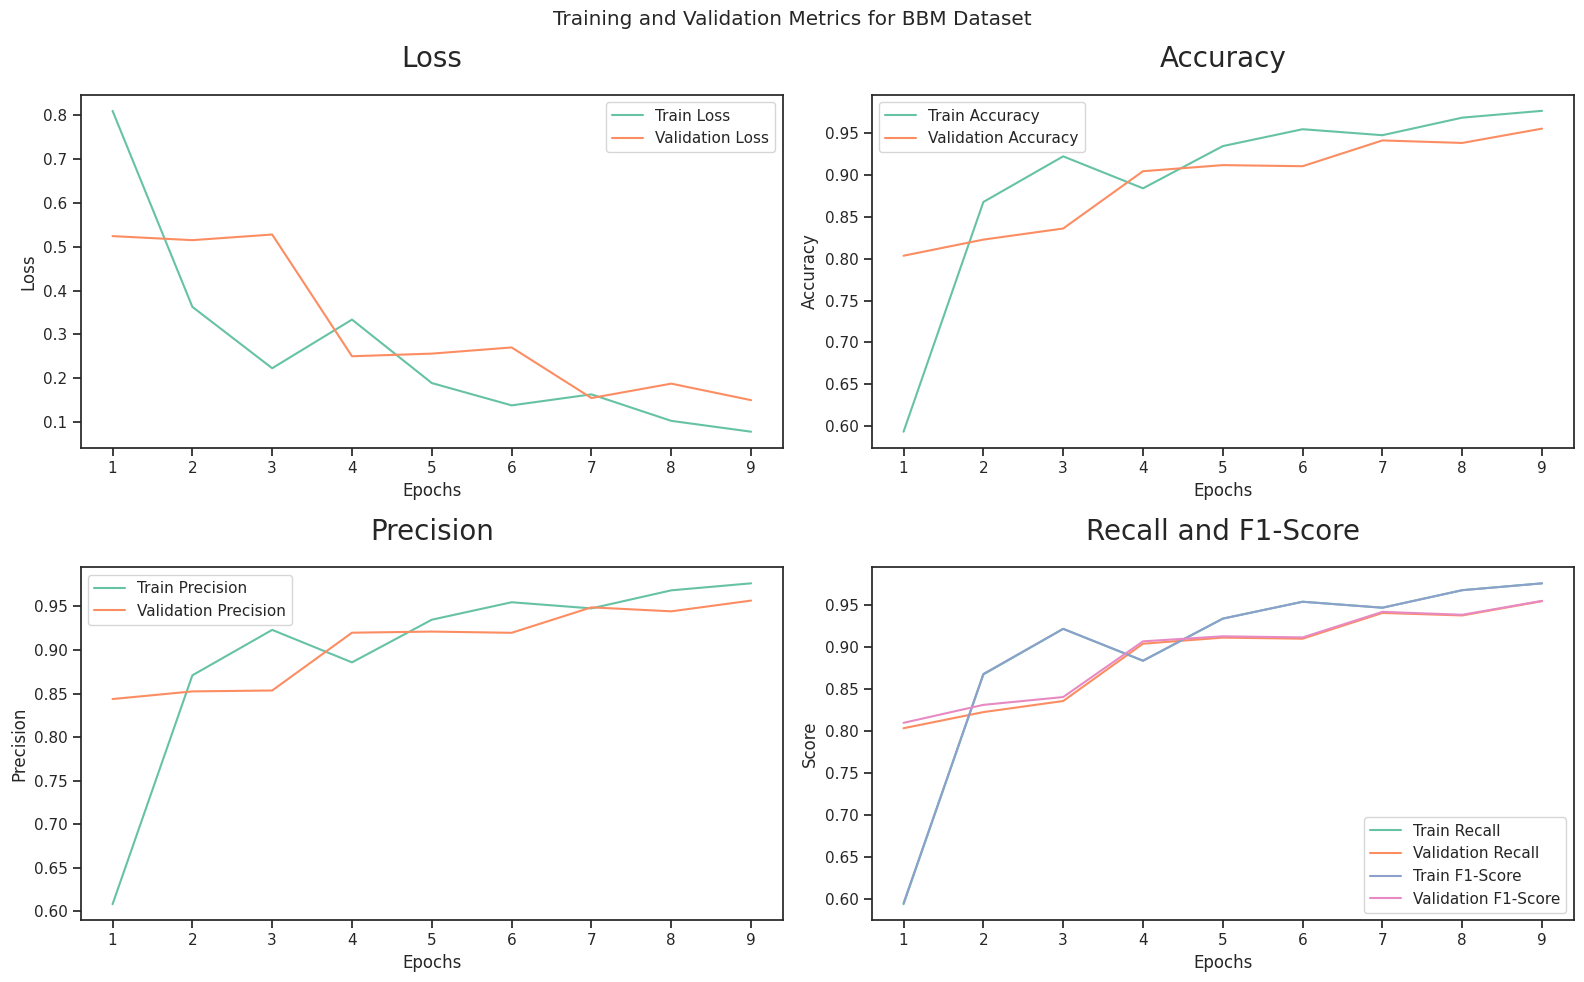

In [25]:
# Plot the history for both datasets
# plot_history(history_pemilu, "Training and Validation Metrics for Pemilu Dataset"),
plot_history(history_bbm, "Training and Validation Metrics for BBM Dataset")

# Graveyard

# Documentation

Step-by-Step Guide
1. Understand the BERT Architecture
BERT Base has 12 encoder layers.
We can decide how many layers to unfreeze per epoch based on:
Total epochs.
Desired unfreezing strategy (e.g., unfreeze 2 layers per epoch).
2. Define an Unfreezing Schedule
Option 1: Uniform Unfreezing

Unfreeze a fixed number of layers each epoch.
Example: For 5 epochs, unfreeze 2 layers per epoch.
Option 2: Exponential Unfreezing

Start by unfreezing few layers and gradually increase.
Example: Unfreeze 1 layer at epoch 1, 2 layers at epoch 2, etc.
Option 3: Custom Schedule

Define exactly which layers to unfreeze at each epoch.
We'll implement Option 1 (Uniform Unfreezing) for simplicity, but you can easily modify it for other strategies.

3. Adjust Learning Rates Accordingly
When new layers are unfrozen, they should have appropriate learning rates.
We need to redefine or adjust the optimizer when layers are unfrozen.
4. Complete Updated Code
We'll write a function that:

Calculates how many layers to unfreeze per epoch.
Updates the optimizer with discriminative learning rates whenever layers are unfrozen.
Uses Slanted Triangular Learning Rates (STLR) throughout training.


Layer unfreezing is a technique primarily used in transfer learning, where you gradually "unfreeze" or make trainable certain layers of a pre-trained model during the training process. The main idea is to allow the model to fine-tune its weights progressively, starting from the higher (more task-specific) layers and gradually moving towards the lower (more general) layers.

How Layer Unfreezing Works
Initial Freezing:

When you load a pre-trained model, you typically freeze all layers initially. This means that the weights in these layers are not updated during the initial phases of training. The rationale is that the earlier layers of the model have learned to capture general features (e.g., edges in images or basic syntax in text) that are useful across different tasks.
Gradual Unfreezing:

During training, you start unfreezing the layers one by one or in groups. The idea is to allow the model to adjust its weights more specifically to the new task as training progresses.
Higher Layers First: You usually start unfreezing the higher layers (closer to the output) because these layers are more specific to the particular task the model was originally trained on. As you move towards the lower layers, the model adjusts more general features learned from the original dataset.
Lower Layers Later: Lower layers capture more general patterns that are useful across various tasks. These are typically unfrozen later in the training process to avoid distorting the useful general features too early.
Why Use Layer Unfreezing?
Fine-Tuning: This approach allows you to fine-tune the model gradually, which can lead to better performance, especially when your new task is somewhat similar but not identical to the task the model was originally trained on.
Avoiding Overfitting: By unfreezing layers progressively, you reduce the risk of overfitting early in the training process, as the model is less likely to make large adjustments to its weights in the early stages.
Efficient Use of Pre-trained Models: Layer unfreezing helps to make the most out of pre-trained models, especially when computational resources are limited. It allows you to leverage pre-existing knowledge effectively while still adapting to new data.

Understanding the Problem of No Gradient info  
Frozen Layers: The message "Epoch 1: All layers frozen" suggests that the layers of your BERT model have been set to requires_grad=False, which prevents their weights from being updated during backpropagation. This is often done when fine-tuning a pre-trained model and only training the final classification layers.

No Gradient Computation: Since all layers are frozen, no gradients are being calculated, which explains why scaler.step(optimizer) fails due to the absence of gradients.